In [17]:
import mne
import os

raw_data = []
raw_dir = os.path.join('..', 'raw')

n = 1
file_name = 'surround_sup_r1_' # enter filename, no index
while True:
    fname = os.path.join(raw_dir, f'{file_name}{n}.set')
    if not os.path.exists(fname):
        print(f'No file found: {fname} — stopping (last checked {n}).')
        break
        
    print(f'Processing: {fname}')
    raw = mne.io.read_raw_eeglab(fname, preload=True)

    raw_data.append(raw)
    n += 1
raw_data

Processing: ..\raw\surround_sup_r1_1.set


C:\Users\JINQI\AppData\Local\Temp\ipykernel_45900\878603456.py:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(fname, preload=True)


Processing: ..\raw\surround_sup_r1_2.set


C:\Users\JINQI\AppData\Local\Temp\ipykernel_45900\878603456.py:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(fname, preload=True)


Processing: ..\raw\surround_sup_r1_3.set
No file found: ..\raw\surround_sup_r1_4.set — stopping (last checked 4).


[<RawEEGLAB | surround_sup_r1_1.set, 129 x 157712 (315.4 s), ~155.4 MiB, data loaded>,
 <RawEEGLAB | surround_sup_r1_2.set, 129 x 729933 (1459.9 s), ~718.5 MiB, data loaded>,
 <RawEEGLAB | surround_sup_r1_3.set, 129 x 461863 (923.7 s), ~454.7 MiB, data loaded>]

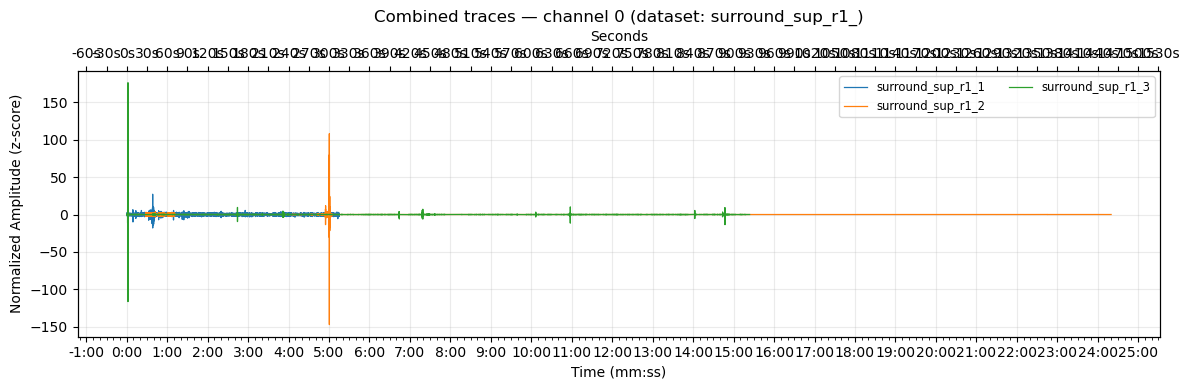

In [19]:
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

chan_name = 0

def format_mmss(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f"{minutes}:{seconds:02d}"

if len(raw_data) == 0:
    print('selected dataset is empty — run the loader cell (Cell 1) first to populate recordings.')
else:
    plt.figure(figsize=(12, 4))
    ax = plt.gca()

    cmap = plt.get_cmap('tab10')
    n_recs = len(raw_data)

    for i, raw in enumerate(raw_data):
        data = raw.get_data(picks=[chan_name])[0]
        sfreq = raw.info['sfreq']

        # use the full recording (no trimming)
        data_trim = data
        ts = np.arange(len(data_trim)) / sfreq

        try:
            from biosppy.signals import eeg
            out = eeg.eeg(signal=data_trim, sampling_rate=sfreq, show=False)
            trace = zscore(out['filtered'])
        except Exception:
            trace = zscore(data_trim)

        color = cmap(i % cmap.N)
        ax.plot(ts, trace, label=f'{file_name}{i+1}', color=color, linewidth=0.9)

    ax.set_xlabel('Time (mm:ss)')
    ax.set_ylabel('Normalized Amplitude (z-score)')
    ax.set_title(f'Combined traces — channel {chan_name} (dataset: {file_name})')
    ax.grid(True, alpha=0.25)

    # Bottom axis formatting: minutes (major) and 10s minor ticks
    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_mmss))

    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.xaxis.set_major_locator(ticker.MultipleLocator(30))
    ax_top.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x)}s"))
    ax_top.set_xlabel('Seconds')

    ax.legend(loc='upper right', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()